<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Example 3 - Available potential energy (APE)**

Available potential energy is the part of potential energy of a body of fluid that is theoretically 'available' for conversion into kinetic energy. The other part, known as background potential energy, cannot be converted into kinetic energy and is typically associated with a stable equilibrium state ([Lorenz, E.N. (1955)](https://doi.org/10.1111/j.2153-3490.1955.tb01148.x)). For example, kinetic energy cannot typically be extracted from a stably stratified environment (in which a fluid's density decreases with height) and therefore possesses zero available potential energy. The reference state that is used to define global available potential energy (cf. [Lorenz, E.N. (1955)](https://doi.org/10.1111/j.2153-3490.1955.tb01148.x) and [Winters et al. (1995)](https://doi.org/10.1017/S002211209500125X)), which quantifies the maximum amount of potential energy that can be released during a volume-preserving and adiabatic rearrangement of fluid parcels, is a functional of the joint PDF of buoyancy and geo-potential height. [Tseng, Y. & Ferziger, J.H. (2001)](https://doi.org/10.1063/1.1358307) showed that the reference state in APE constructions is closely related to the cumulative distribution of buoyancy over a domain. 


The APE of a buoyancy field $B(\mathbf{x})$ of vertical extent $Z(\mathbf{x})$ is given by the difference of its total potential energy (TPE) and the (minimal) background potential energy (BPE) according to 
\begin{equation}
\mathbb{E}[BZ^*]  - \mathbb{E}[BZ] = \iint b \left(Z^*(b) -z \right) \; f_{BZ}(b,z) \; dbdz = \underbrace{\int b Z^*(b) f_B db}_{BPE} - \underbrace{\iint bz f_{BZ}(b,z) \; dbdz,}_{TPE}
\end{equation}
where the reference state
\begin{equation}
Z^*(b) = F^{-1}_Z \circ F_B(b) = Q_Z \circ F_B(b),
\end{equation}
corresponds to an adiabatic volume preserving rearrangement of the fluid into a state that minimizes TPE. Provided $Z^*(b)$ constitutes a valid test function the integral for BPE defines a distribution and can be evaluated (cf. [Ern, A., Guermond, JL. (2021)](https://doi.org/10.1007/978-3-030-56341-7_4)). If however $B(\mathbf{x})$ corresponds to a layered stratification, $F_B(b)$ will contain step and the previous integral is no longer well defined. In such circumstances it is preferable to calculate APE as
\begin{equation}
\mathbb{E}[\beta^*(Z) Z]  - \mathbb{E}[BZ] = \iint \left(\beta^*(z) - b \right) z f_{BZ}(b,z) \; dbdz = \underbrace{\int \beta^*(z) z f_Z \; dz}_{BPE} - \underbrace{\iint bz f_{BZ}(b,z) \; dbdz,}_{TPE}
\end{equation}
where the mapping is given by
\begin{equation}
\beta^*(z) = F^{-1}_B \circ F_Z(z) = Q_B \circ F_Z(z).
\end{equation}
As $Q_B$ is by definition continuous even for layered stratifications and the CDF of the domain height (or geo-potential) $F_Z$ does not contain jumps (at least in physically or computationally realisable domains) this mapping ensures the latter distribution for BPE is well defined. In this notebook we demonstrate using two examples how the reference state and in-turn the APE can be calculated using *NumDF*.

**A) Layered stratification**

For the first example we will consider the buoyancy field and potential
\begin{align}
    B(x_1,x_2) &= \frac{1}{2} \left( \tanh \left( \alpha(x_2 - 1/2) \right) + \tanh \left(\alpha(x_2 + 1/2) \right) \right),\\
    Z(x_1,x_2) &= x_2,
\end{align}
and define the physical domain as $\Omega_X \in [-1,1] \times [-1,1]$, such that the buoyancy domain is $\Omega_B \in [-1,1]$ and that of the potential is $\Omega_Z \in [-1,1]$. A visualization of the layered buoyancy field $B(\mathbf{x})$ is given below. As this function is stably stratified its total potential energy is $\approxeq -3/8$ the background potential energy $ \approxeq 3/8$ (in the limit $\alpha \gg 1$) and so we should recover that the APE is almost zero in our calculation. 

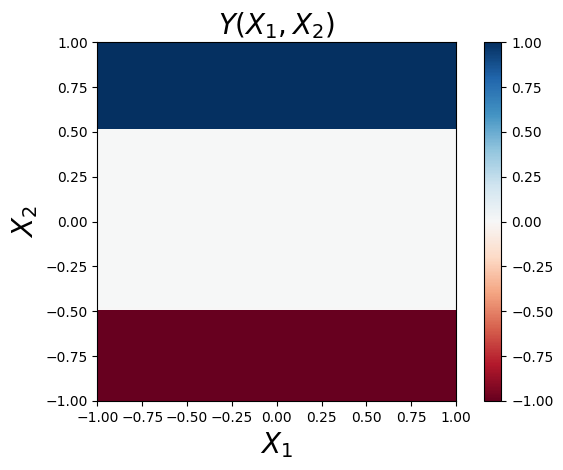

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def Y_numerical(X, alpha = 1000):
    """Return Y(X)."""
    x1, x2 = X[:,0], X[:,1]    
    return .5*( np.tanh(alpha*(x2-.5) ) + np.tanh(alpha*(x2 +.5) ) )

x = np.linspace(-1, 1, 10**2)
z = np.linspace(-1, 1, 10**2)
[x1, x2] = np.meshgrid(x,z, indexing='ij')

X = np.vstack( (x1.flatten(), x2.flatten())).T
Y = Y_numerical(X).reshape(x2.shape)[:-1, :-1]

fig, ax0 = plt.subplots()
im = ax0.pcolormesh(x1, x2, Y, cmap=plt.get_cmap('RdBu'))
ax0.set_title(r'$Y(X_1,X_2)$',fontsize=20)
ax0.set_xlabel(r'$X_1$',fontsize=20)
ax0.set_ylabel(r'$X_2$',fontsize=20)
ax0.set_box_aspect(1)
fig.colorbar(im, ax=ax0, orientation='vertical')
fig.tight_layout()
plt.show()

In order to compute the APE of this field we shall use make use of the second formulae as the CDF $F_Z$ does not contain steps. To construct the buoyancy's inverse CDF $F^{-1}_B$ and the vertical coordinate's PDF $f_Z$ and CDF $F_Z$ we make use of the *NumDF* class as well as [Firedrake](https://www.firedrakeproject.org/) (which is required to evaluate integrals) both of which are imported below.

In [38]:
from numdf import Ptp
from firedrake import *

We first initialise a Ptp object by prescribing the domain $\Omega_X$, range $\Omega_Y$ and the number of finite elements/bins we will use. As the functions are 1D we prescribe the domain for $x_1$ only to simplify the calculation.

In [39]:
ptp = Ptp(Omega_X={'x1': (-1, 1)}, Omega_Y={'Y': (-1, 1)}, n_elements=200)

We then grab the coordinate functions and write our fields $B$ and $Z$ in terms of these

In [40]:
alpha = 1000
x2 = ptp.x_coords()
B = ( tanh(alpha*(x2 - 1/2)) + tanh(alpha*(x2 + 1/2)) )/2
Z = x2

For each of these fields we have just created we now create their associated density objects by calling the fit method.

In [41]:
density_B = ptp.fit(Y=B, quadrature_degree=2000)
density_Z = ptp.fit(Y=Z, quadrature_degree=2000)

Plotting their respective CDF's below we can confirm that two distinct density objects have been created.

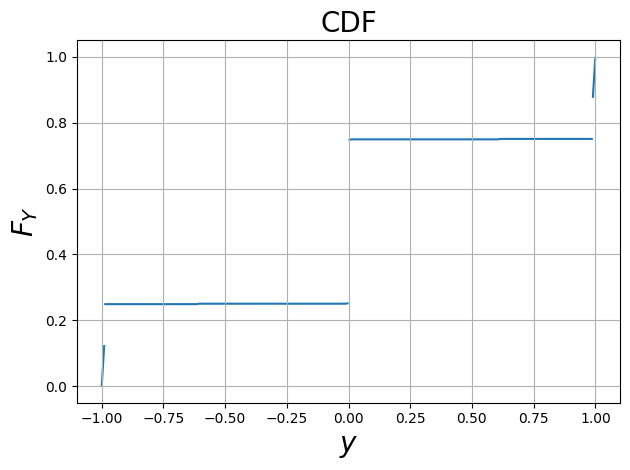

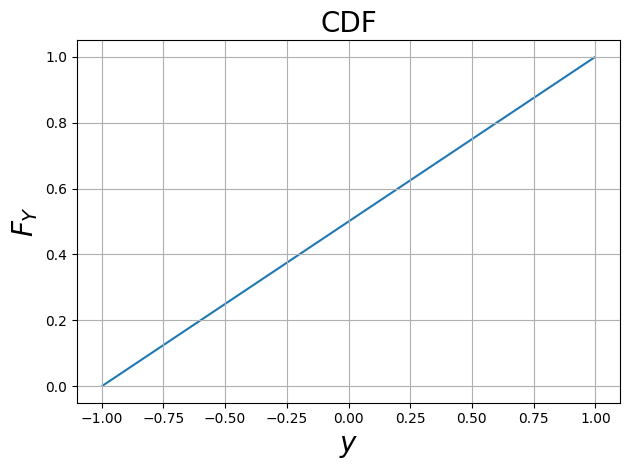

In [42]:
density_B.plot('CDF')
density_Z.plot('CDF')

To obtain the mapping $\beta^*(z)$ we evaluate the function composition $\beta^*(z) = Q_B \circ F_Z(z)$, at a number of quadrature points, using the compose method associated with the density class

In [43]:
Q_B = density_B.qdf
F_Z = density_Z.cdf
beta_star = density_Z.compose(Q_B, F_Z, quadrature_degree=2000)

To evaluate the background potential energy (bpe) we then integrate the expression
\begin{equation}
\mathbb{E}[\beta^*(Z)Z] = \int \beta^*(z) z f_{Z}(z) \; dz,
\end{equation}
by passing $\beta^*(z) z$ as a test-function to the distribution corresponding to $f_{Z}(z)$.

In [44]:
z = density_Z.y
bpe_num = density_Z.distribution(beta_star*z)

The available potential energy is then given by

In [45]:
ape_num = bpe_num - 3/8

print('APE numerical using f_Z = %0.6f \n'%ape_num)

APE numerical using f_Z = -0.002562 



which is close to zero as anticipated. Repeating the calculation in terms of the reference height $Z^*(b) = Q_Z \circ F_B(b)$, we must integrate the expression
\begin{equation}
\mathbb{E}[BZ^*] = \int b Z^*(b) f_{B}(b) \; db,
\end{equation}
in order to evaluate the background potential energy. This is achieved by passing $b Z^*(b)$ as a test-function to the distribution corresponding to $f_{B}(b)$. As shown below this calculation is less accurate due to the fact that $F_B$ and therefore $Z^*(b)$ contains steps and cannot consistently be projected into the space of test functions (here realised as 'CG1').

In [46]:
Q_Z = density_Z.qdf
F_B = density_B.cdf
Z_star = density_B.compose(Q_Z, F_B, quadrature_degree=2000)

b = density_B.y
bpe_num = density_B.distribution(b*Z_star)

ape_num = bpe_num - 3/8
print('APE numerical using f_B = %0.6f \n'%ape_num)

APE numerical using f_B = 0.007249 



**B) Kelvin-Helmholtz instability**

For the second example we will compute the APE of the buoyancy field $B(\mathbf{x})$ of a time evolving simulation of the Kelvin-Helmholtz instability generated using [Dedalus](https://dedalus-project.org/). The dataset we use contains snapshots at $T=[1,2, \cdots, 24]$ while the simulation details, equations and Dedalus script are available in the folder $\texttt{KelvinHelmholtz}$. Following the previous example we write a function *Y_numerical* which returns the value of the function at a set of quadrature points

In [47]:
import h5py
from scipy.interpolate import RegularGridInterpolator

def Y_numerical(X, time=2):
    """Return Y(X)."""

    f = h5py.File('data/KelvinHelmholtz/snapshots_s1.h5','r')
    Y = f['tasks/buoyancy'][time, ...]
    x = f['tasks/buoyancy'].dims[1][0][:]
    z = f['tasks/buoyancy'].dims[2][0][:]
    f.close()

    return RegularGridInterpolator((x, z), Y, bounds_error=False)(X)

Using *Y_numerical* we then plot snapshots of this data at different time-instants on a regular grid

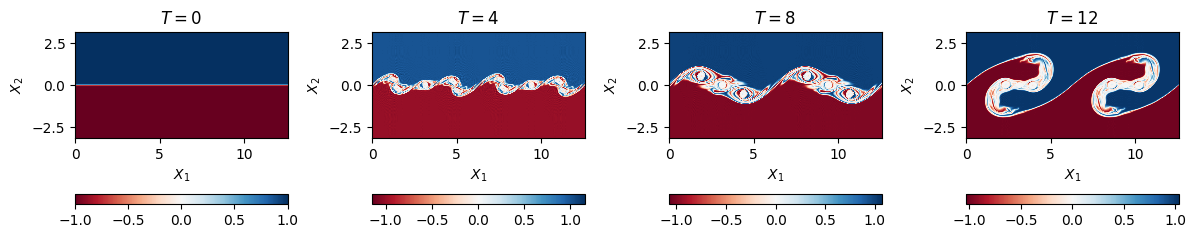

In [48]:
dx1, dx2 = 0.01, 0.01
x2, x1 = np.mgrid[slice(-np.pi,np.pi + dx1, dx1), slice(0, 4*np.pi + dx2, dx2)]
X = np.vstack( (x1.flatten(), x2.flatten())).T

fig, ax = plt.subplots(ncols=4,figsize=(12,4))

for ax0,time in zip(ax, [0,4,8,12]):

    Y = Y_numerical(X,time).reshape(x2.shape)[:-1, :-1]

    cmap = plt.get_cmap('RdBu')
    im = ax0.pcolormesh(x1, x2, Y, cmap=cmap)
    ax0.set_title(r'$T=%d$'%time)
    ax0.set_xlabel(r'$X_1$')
    ax0.set_ylabel(r'$X_2$')
    ax0.set_box_aspect(0.5)
    fig.colorbar(im, ax=ax0, orientation='horizontal')

fig.tight_layout()
plt.show()

To compute the APE we create a *ptp* object which specifies the domain size, the function's range and the number of finite elements. As the geo-potential $Z$ and buoyancy field $B$ have different ranges and require a different number of elements we specify two objects

First we compute the density of the geo-potential or domain height $Z=X_2$

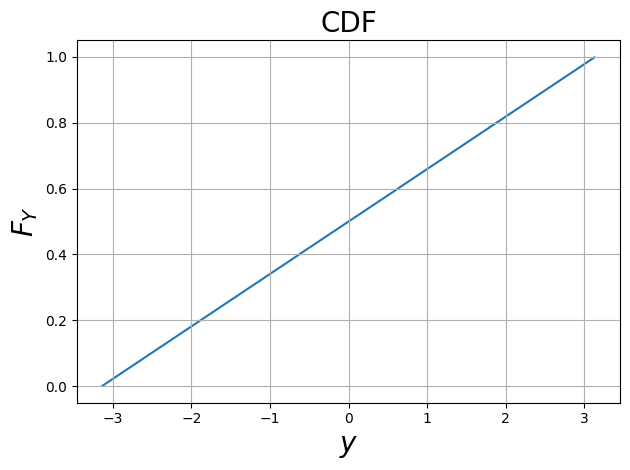

In [49]:
ptp_Z = Ptp(Omega_X={'x1': (0, 4*np.pi), 'x2': (-np.pi, np.pi)}, Omega_Y={'Y': (-np.pi, np.pi)}, n_elements=5)

x1,x2 = ptp_Z.x_coords()
density_Z = ptp_Z.fit(Y = x2, quadrature_degree=200)

density_Z.plot('CDF')

and then we compute the density of the buoyancy field $B(\mathbf{x})$ and a particular time $t$

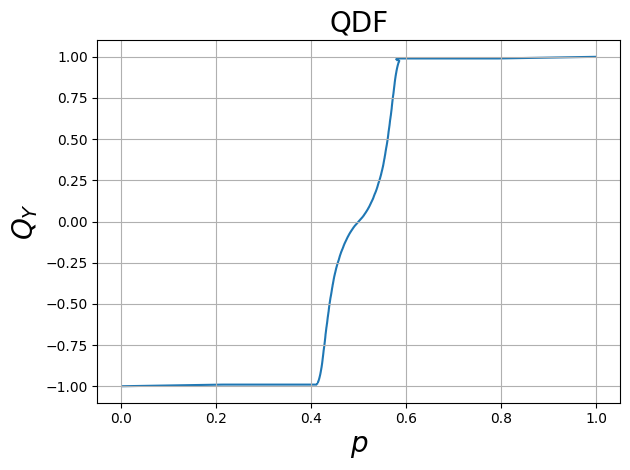

In [50]:
ptp_B = Ptp(Omega_X={'x1': (0, 4*np.pi), 'x2': (-np.pi, np.pi)}, Omega_Y={'Y': (-1,1)}, n_elements=200)

t = 10 # Choose the time-instant

B = lambda X: Y_numerical(X,time=t)
density_B = ptp_B.fit(Y=B, quadrature_degree=1000)

density_B.plot('QDF')


We then extract the CDF $F_Z$ and QDF $Q_B$ from these density objects for mapping $\beta^*(Z) = Q_B \circ F_Z$. To compute the mapping we then use the compose method associated with the density class

In [51]:
F_Z = density_Z.cdf
Q_B = density_B.qdf
beta_star = density_B.compose(Q_B, F_Z, quadrature_degree=2000)

To evaluate the background potential energy (bpe) we then integrate the expression
\begin{equation}
\mathbb{E}[\beta^*(Z)Z] = \int \beta^*(z) z f_{Z}(z) \; dz,
\end{equation}
by passing $\beta^*(z) z$ as a test-function to the distribution corresponding to $f_{Z}(z)$.

In [52]:
z = density_Z.y
bpe = density_Z.distribution(beta_star*z)

To calculate the total potential energy (tpe) we evaluate the integral
\begin{equation}
\mathbb{E}[BZ] = -\frac{1}{V}\int B(X) Z(X) dX, 
\end{equation}
by integrating over $\Omega$. Although this can be computed by importing the data into Firedrake we load the tpe calculated in Dedalus as much like the BPE is more accurately calculated by projecting the CDF into $L^2$ the tpe is more accurately calculated in spectral space in Dedalus.

In [53]:
def tpe(time=2):
    """Return the TPE at time t"""

    f = h5py.File('data/KelvinHelmholtz/snapshots_s1.h5','r')
    B = f['tasks/buoyancy'][time, ...]
    x = f['tasks/buoyancy'].dims[1][0][:]
    z = f['tasks/buoyancy'].dims[2][0][:]
    f.close()

    Z = np.outer(np.ones(len(x)),z)
    
    V = 8*(np.pi**2)

    return -(1/V)*np.trapezoid(y=np.trapezoid(y=B*Z,x=x,axis=0),x=z )

The available potential energy is then given by 

In [54]:
TPE = tpe(time=t)
APE = bpe + TPE
print('Kelvin Helmholtz')
print('BPE(t = %d) = %6.6f   '%(t,bpe))
print('TPE(t = %d) = %6.6f   '%(t,TPE))
print('APE(t = %d) = %6.6f \n'%(t,APE))

Kelvin Helmholtz
BPE(t = 10) = 1.458497   
TPE(t = 10) = -1.355958   
APE(t = 10) = 0.102539 

